## Here it starts !!

In this notebook, I keep track of my own health parameters related to the thyroide metabolism. As being a person with a surgically removed thyroid gland, I am dependent constantly on intake of the thyroxine hormone. 

The problem with this is that the feedback loop that was naturally present for controling the amount of thyroxine horminoe being produced by the gland is not anymore functional —as there is no more gland. 

The recommended daily amount of thyroxine is thought to be between 150 and 200 µgr, with the body size being one important factor scaling this need. 

Typically doctors tell their patients that once the daily dosage is fixed, this dosage would be appropriate for a person, with trimenstrial blood-analysis checks to ensure that parameters are within the normal range.

These blood analyses tests for the concentration of TSH (thyroid stimulating hormone), which is the hormone produced by the hypothalamus, in the central nervous system in response to the thyroid hormone. The more hormone there is, the less TSH is produced by the brain, in an attemp to stop stimulating the thyroid gland. 

In reality however, the subjective feelings of well-being can change considerably with even the same amount of throxine hormone intake. The reasons driving this are not well understood but it is thought that many factors contribute to this.

There are pleathora of side effects due to wrong thyoxin dosage. Change in weight, change in mood, feeling tired, painful bones, joint pain, heart palpitations, and many others

In this notebook, my aim is to understand this interplay between the thyroxin dosage and different physiological and psychological measurements. And ultimately to monitor the state of parameters and the way how they drift from an healthy region. 

For the one who is willing to track their own psy/physiological states, it is surprising to realize that this task is a really hard one when one doesn't use a diary. For the reason that human memory really fails miserably when it is about "how was I feeling 7 months ago when I was in the regime of my previous dosage?". Therefore another aim of this notebook is to create a place as a dairy journal which helps us to remind my subjective feelings with dosage parameters.

### Collected data modalities

- TSH (lab results, 3-6 times a year)
- Dosage (doctor's visit, 3-6 times a year)
- General mood score (daily with the Daylio app)
- Different complaints (such joint pain, chest pain, also from Dayio app)
- Weight (iOS health app entered manually daily)
- Physical activity (iOS native app, daily)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#some functions to plot different modalities.

#plot the TSH levels
def plot_TSH(df_test,ax):
    i = df_test["TSH"].isna()
    df_test = df_test.loc[~i]
    ax.plot(df_test['test_date'], df_test['TSH'], 
                             marker='o' , 
                             color='k' , 
                             markersize=15,                         
                             linewidth=4,
                             label='TSH')
    ax.set( ylabel="TSH (mU/l)")
    ax.set_yscale('log')
    plt.xticks(rotation=45,ha='right')
    import matplotlib.dates as mdates
    months = mdates.MonthLocator() 
    years_fmt = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(years_fmt)
    


def plot_health_band(df2,ax):
    import matplotlib.patches as patches
    import matplotlib.dates as mdates

    # # Plot rectangle
    # convert to matplotlib date representation
    start = mdates.date2num(df2.ds.iloc[0])
    end   = mdates.date2num(df2.ds.iloc[-1])
    width = end - start
    rect  = patches.Rectangle((start, 0.27), width, 4, color='lightgreen')
    ax.add_patch(rect)

def plot_dosage(df2,ax):
    # Plot the dosage of thyroxine intake
    ax.plot(df2.ds, 
            df2.dosage,
             color='r',
             markersize=10,
             linewidth=3,
             label='dosage')
    import matplotlib.dates as mdates
    months    = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')
    month_fmt = mdates.DateFormatter('%Y-%m')

    ax.set( ylabel="Dosage (µgr)",xticks=[])
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    plt.xticks(rotation=45)
    ax.grid(True)
    
def plot_mood(df_mood,ax):
    # Plot mood data from Daylio app export
    bla, = ax.plot(df_mood.index,df_mood.mood,marker='o',color='m',markersize=10,label='mood')
    ax.yaxis.label.set_color(bla.get_color())
    ax.set( ylabel="Mood",xticks=[])
    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=bla.get_color(),**tkw)
    
def plot_weight(df,ax):
    # Plot weight
    bla, = ax.plot(df_weight.index,df_weight["weight_mean"],marker='o',color='b',markersize=5,label='weight')
    ax.yaxis.label.set_color(bla.get_color())
    ax.set( ylabel="Weight",xticks=[])
    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=bla.get_color(),**tkw)
    
# get blood test results
# this will return a df with the following information
# ['test_date','TSH','T3','T4','medication_change_start','medication_change_stop','dosage']
def get_lab_results():
    df_lab  = pd.read_csv( "./data/BloodTests.csv",  #the file that is updated with each lab result
                        delimiter=',',
                        header=None,
                        names=['test_date','TSH','T3','T4','medication_change_start','medication_change_stop','dosage'])#double check t3 vs t4

    df_lab["test_date"]               = pd.to_datetime(df_lab["test_date"],format='%d-%m-%Y')
    df_lab["medication_change_start"] = pd.to_datetime(df_lab["medication_change_start"],format='%d-%m-%Y')
    df_lab["medication_change_stop"]  = pd.to_datetime(df_lab["medication_change_stop"],format='%d-%m-%Y')
    
    #just take a subset to plot
    df_dosage = pd.concat([pd.DataFrame({'ds'     : df_lab["medication_change_start"],'dosage' : df_lab["dosage"]}),
                           pd.DataFrame({'ds'     : df_lab["medication_change_stop"] ,'dosage' : df_lab["dosage"]})]).sort_values(by='ds')
    
    return df_lab, df_dosage

def read_mood_data():
    # #read mood data
    df_mood       = pd.read_csv("./Daylio_export.csv",usecols=[0,4])
    df_mood.index = pd.to_datetime(df_mood["full_date"])
#     df_mood["month"] = df_mood.index.month
#     df_mood["week"]  = df_mood.index.week
#     df_mood["year"]  = df_mood.index.year
    df_mood.sort_index(inplace=True)
    #if you comment resample the full df contains all sort of notes.
#     df_mood       = df_mood.resample('SMS', convention='start').mean()
    df_mood       = df_mood.resample('W', convention='start').mean()
    #check list of abbrevations here:
    #https://stackoverflow.com/questions/17001389/pandas-resample-documentation 
    #
    return df_mood

def get_activities():
    # #read mood data
    df_mood       = pd.read_csv("./Daylio_export.csv",usecols=[0,4,5])
    df_mood.index = pd.to_datetime(df_mood["full_date"])
    df_mood.sort_index(inplace=True)
    # expand multi activities
    act = df_mood["activities"].str.split("|",expand = True)
    #remove spaces
    for col in act:
        act[col] = act[col].str.strip()
    # activities = list()
    # for c in act.columns:
    #     activities = activities  + (act[c].unique().tolist())
    # activities
    # pd.get_dummies(act[0]).T
    act = pd.get_dummies(act.stack().droplevel(1))
    return act

<IPython.core.display.Javascript object>


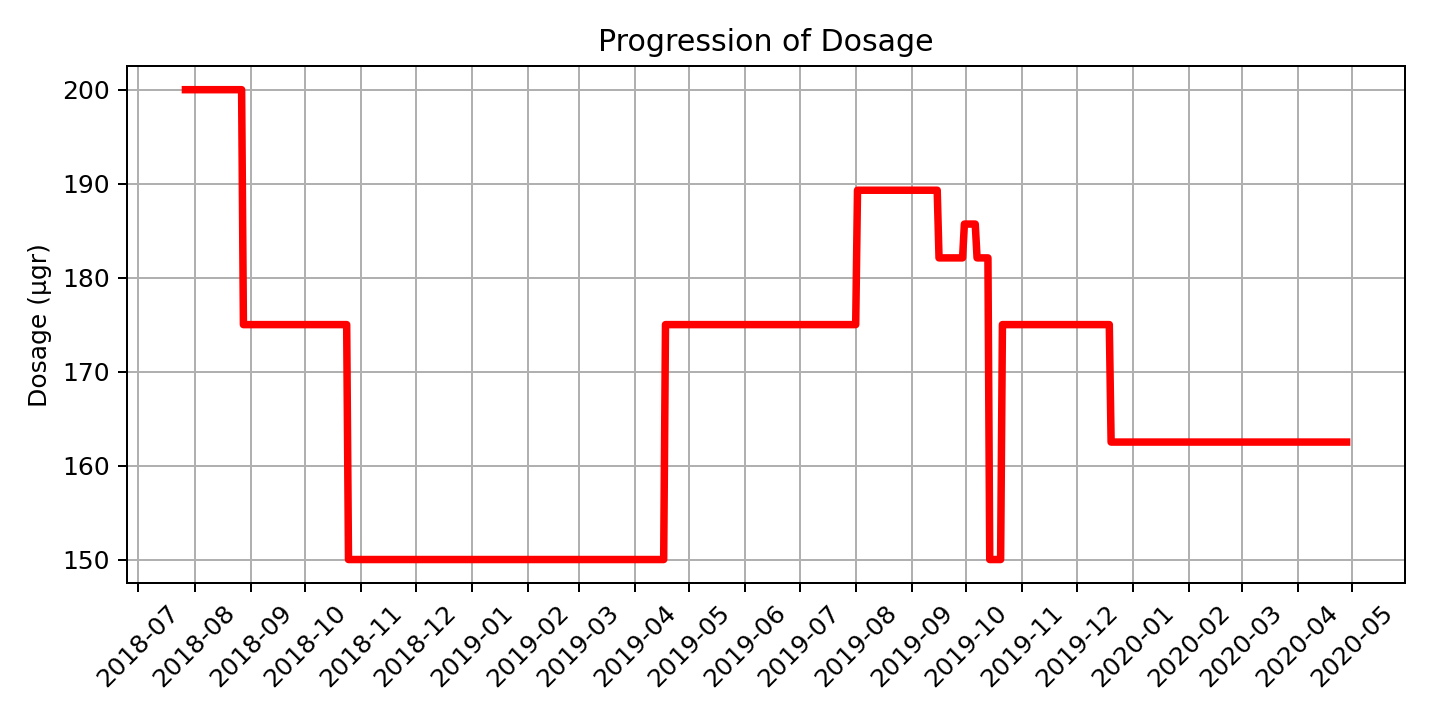

In [2]:
df_lab, df_dosage = get_lab_results()
fig, host   = plt.subplots(1,1,figsize=(8,4))
fig.subplots_adjust(right=0.75)
plot_dosage(df_dosage,host)
plt.title('Progression of Dosage')
plt.tight_layout()

# Mood Data from Daylio App

In [3]:
df_mood         = read_mood_data()
df_mood

,mood
full_date,
2018-09-02,8.142857
2018-09-09,8.714286
2018-09-16,8.000000
2018-09-23,8.285714
2018-09-30,8.600000
...,...
2020-03-29,9.000000
2020-04-05,8.250000
2020-04-12,8.500000


# get iOS Health.app data: Weight

In [4]:
# Read iOS Healt.app data export
# read apple health data as a df
def iter_records(healthdata):
    import datetime
    healthdata_attr = healthdata.attrib
    for rec in healthdata.iterfind('.//Record'):
        rec_dict = healthdata_attr.copy()
        rec_dict.update(healthdata.attrib)
        for k, v in rec.attrib.items():
            if 'date' in k.lower():
                rec_dict[k] = datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S %z').date()
            else:
                rec_dict[k] = v
        yield rec_dict
        
def get_applehealth():  
    import xml.etree.ElementTree
    path_to_exportxml = "./apple_health_export/export.xml"
    healthdata        = xml.etree.ElementTree.parse(path_to_exportxml).getroot()
    healthdata_attr   = healthdata.attrib
    print(healthdata_attr)
    
    df_apple = pd.DataFrame.from_dict(iter_records(healthdata))
    df_apple.index = pd.to_datetime(df_apple['startDate'])
    return df_apple

def get_weight_data():
    #read weight data from apple health export
    df_apple = get_applehealth()
    # get weight data
    df_weight       = df_apple.loc[df_apple.type == 'HKQuantityTypeIdentifierBodyMass',['startDate','value']]
    df_weight.value = df_weight.value.astype(float)
    mask            = df_weight.index >= '2018-09'
    df_weight       = df_weight[mask]
    df_weight       = pd.concat([
                                pd.DataFrame({"weight_mean" : df_weight.resample('W')['value'].mean()}),
                                pd.DataFrame({"weight_std"  : df_weight.resample('W')['value'].std() })
                                ],axis=1)
    return df_weight

def get_walking_running():
    #in units of km
    df_apple      = get_applehealth()
    df_exer       = df_apple.loc[df_apple.type == 'HKQuantityTypeIdentifierDistanceWalkingRunning',['startDate','value']]
    df_exer.value = df_exer.value.astype(float)
    df_exer["startDate"] = pd.to_datetime(df_exer["startDate"])
    mask      = df_exer.startDate > '2018-08'
    df_exer   = df_exer[mask]
    df_exer   = df_exer.rename(columns={'value':'km'})
    df_exer   = df_exer.drop(columns='startDate')
    return df_exer
    

#to list different types of events present
# df_apple      = get_applehealth()
# # df_apple.type.unique()
# {'locale': 'en_DE'}
# array(['HKQuantityTypeIdentifierBodyMassIndex',
#        'HKQuantityTypeIdentifierHeight',
#        'HKQuantityTypeIdentifierBodyMass',
#        'HKQuantityTypeIdentifierHeartRate',
#        'HKQuantityTypeIdentifierBloodPressureSystolic',
#        'HKQuantityTypeIdentifierBloodPressureDiastolic',
#        'HKQuantityTypeIdentifierBodyTemperature',
#        'HKQuantityTypeIdentifierStepCount',
#        'HKQuantityTypeIdentifierDistanceWalkingRunning',
#        'HKQuantityTypeIdentifierBasalEnergyBurned',
#        'HKQuantityTypeIdentifierActiveEnergyBurned',
#        'HKQuantityTypeIdentifierFlightsClimbed',
#        'HKQuantityTypeIdentifierAppleExerciseTime',
#        'HKQuantityTypeIdentifierDistanceCycling',
#        'HKQuantityTypeIdentifierWaistCircumference',
#        'HKQuantityTypeIdentifierVO2Max',
#        'HKQuantityTypeIdentifierHeadphoneAudioExposure',
#        'HKCategoryTypeIdentifierSleepAnalysis',
#        'HKCategoryTypeIdentifierAppleStandHour',
#        'HKCategoryTypeIdentifierMindfulSession'], dtype=object)

In [5]:
df_km = get_walking_running()
df_km.head(5)

{'locale': 'en_DE'}


,km
startDate,
2018-08-02,0.049690
2018-08-02,0.058566
2018-08-02,0.037325
2018-08-02,0.187073
2018-08-02,0.232139


In [6]:
df_weight       = get_weight_data()
df_weight.head(3)

{'locale': 'en_DE'}


,weight_mean,weight_std
startDate,,
2018-09-02,98.950000,0.212132
2018-09-09,98.242857,0.243975
2018-09-16,98.016667,0.435507


# Plot All Modalities

<IPython.core.display.Javascript object>


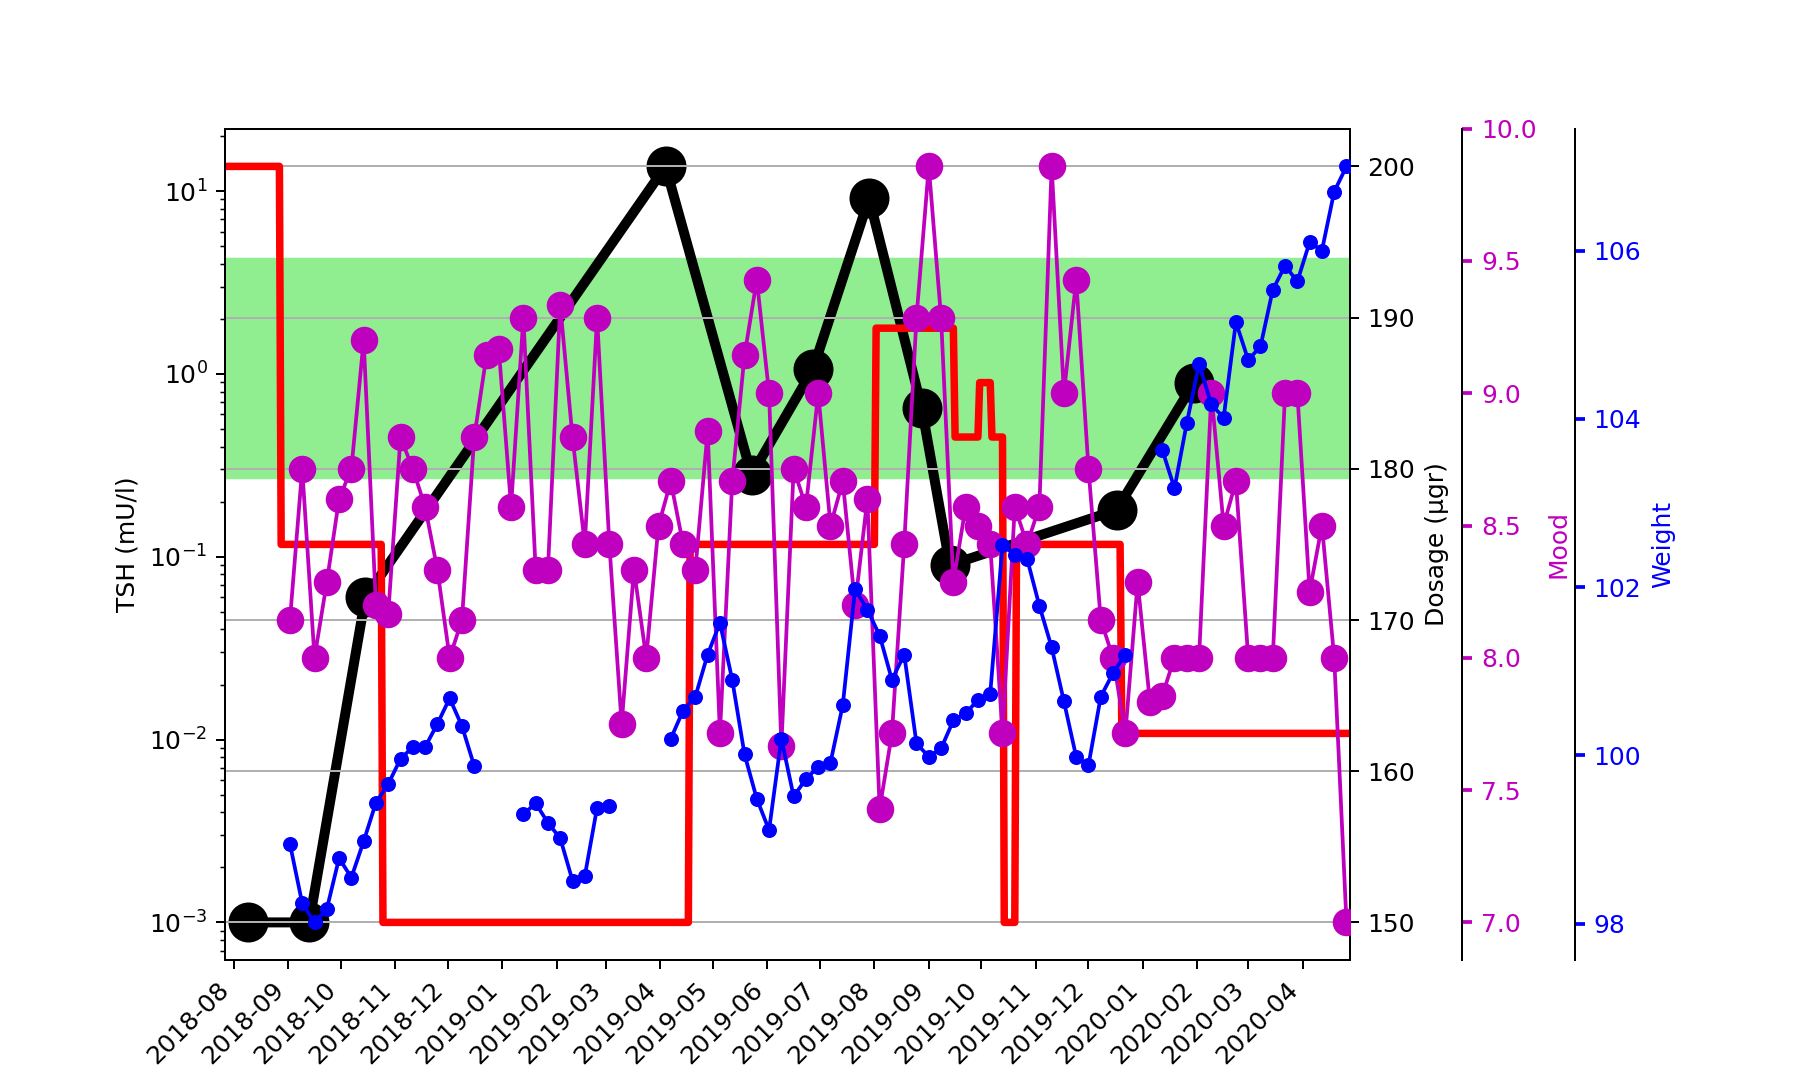

In [7]:
fig, host   = plt.subplots(1,1,figsize=(10,6))

fig.subplots_adjust(right=0.75)

plot_TSH(df_lab,ax=host)
plot_health_band(df_dosage,ax=host)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par2.spines["right"].set_position(("axes", 1.1))
par3.spines["right"].set_position(("axes", 1.2))


plot_mood(df_mood,par2)
plot_weight(df_weight,par3)

plot_dosage(df_dosage,par1)

host.margins(x=0)

### Figure Legend

Left axis: TSH values shown on logaritmic scale. The green band is recommended range of TSH values between 0.27 and 
4.2. The black curve is the serum TSH values, results of blood tests.

The red stepped curved is the currently taken dosage of tyhroxine shown on the right axis.

The purple line is the subjective ratings. Question: "How the fuck do you feel today?", answered everyday at 7:30 am, here averaged for each month. There is no scale for this curve.



# Correlation analysis

The figure above is hard to digest. Let's try to get some insights on this by taking the correlation between different variables. This requires us to align all these measurements in one single data frame with a common time index.

In [8]:
resample_grain = 'W'
df_weight       = get_weight_data().resample(resample_grain).mean()
df_mood         = read_mood_data().resample(resample_grain).mean()
##
df_lab, df_dosage = get_lab_results()
#
df_dosage.set_index('ds',inplace=True)
df_dosage = df_dosage.resample(resample_grain).mean().interpolate(method='linear')
#
df_lab = df_lab[["test_date","TSH"]].dropna()
df_lab.set_index('test_date',inplace=True)
df_lab = df_lab.resample(resample_grain).mean().interpolate(method='linear')
#
df_exer = get_walking_running()
df_exer = df_exer.resample(resample_grain).mean()
#
act = get_activities()
df_activities = act.resample(resample_grain).mean().interpolate(method='linear')
#normalize each column to unit sum
df_activities = df_activities / df_activities.sum(axis=0)

{'locale': 'en_DE'}
{'locale': 'en_DE'}


In [9]:
df = df_mood.join(df_weight["weight_mean"]).join(df_exer).join(df_dosage).join(df_lab)

In [10]:
#this is a second df that contains all data
df_all = df.copy()
df_all = df_all.join(df_activities)

<IPython.core.display.Javascript object>


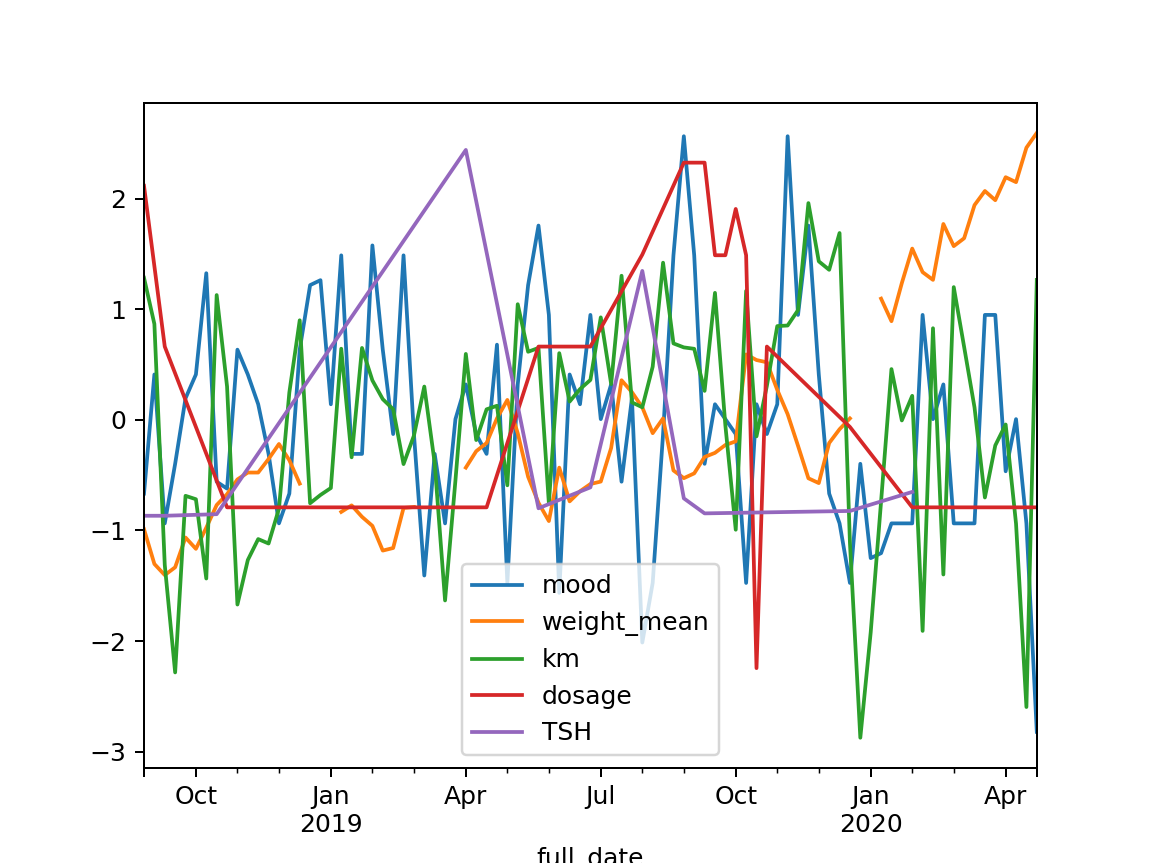

In [11]:
from scipy.stats import zscore
df = df.apply(zscore,nan_policy='omit')
df.plot()

<IPython.core.display.Javascript object>


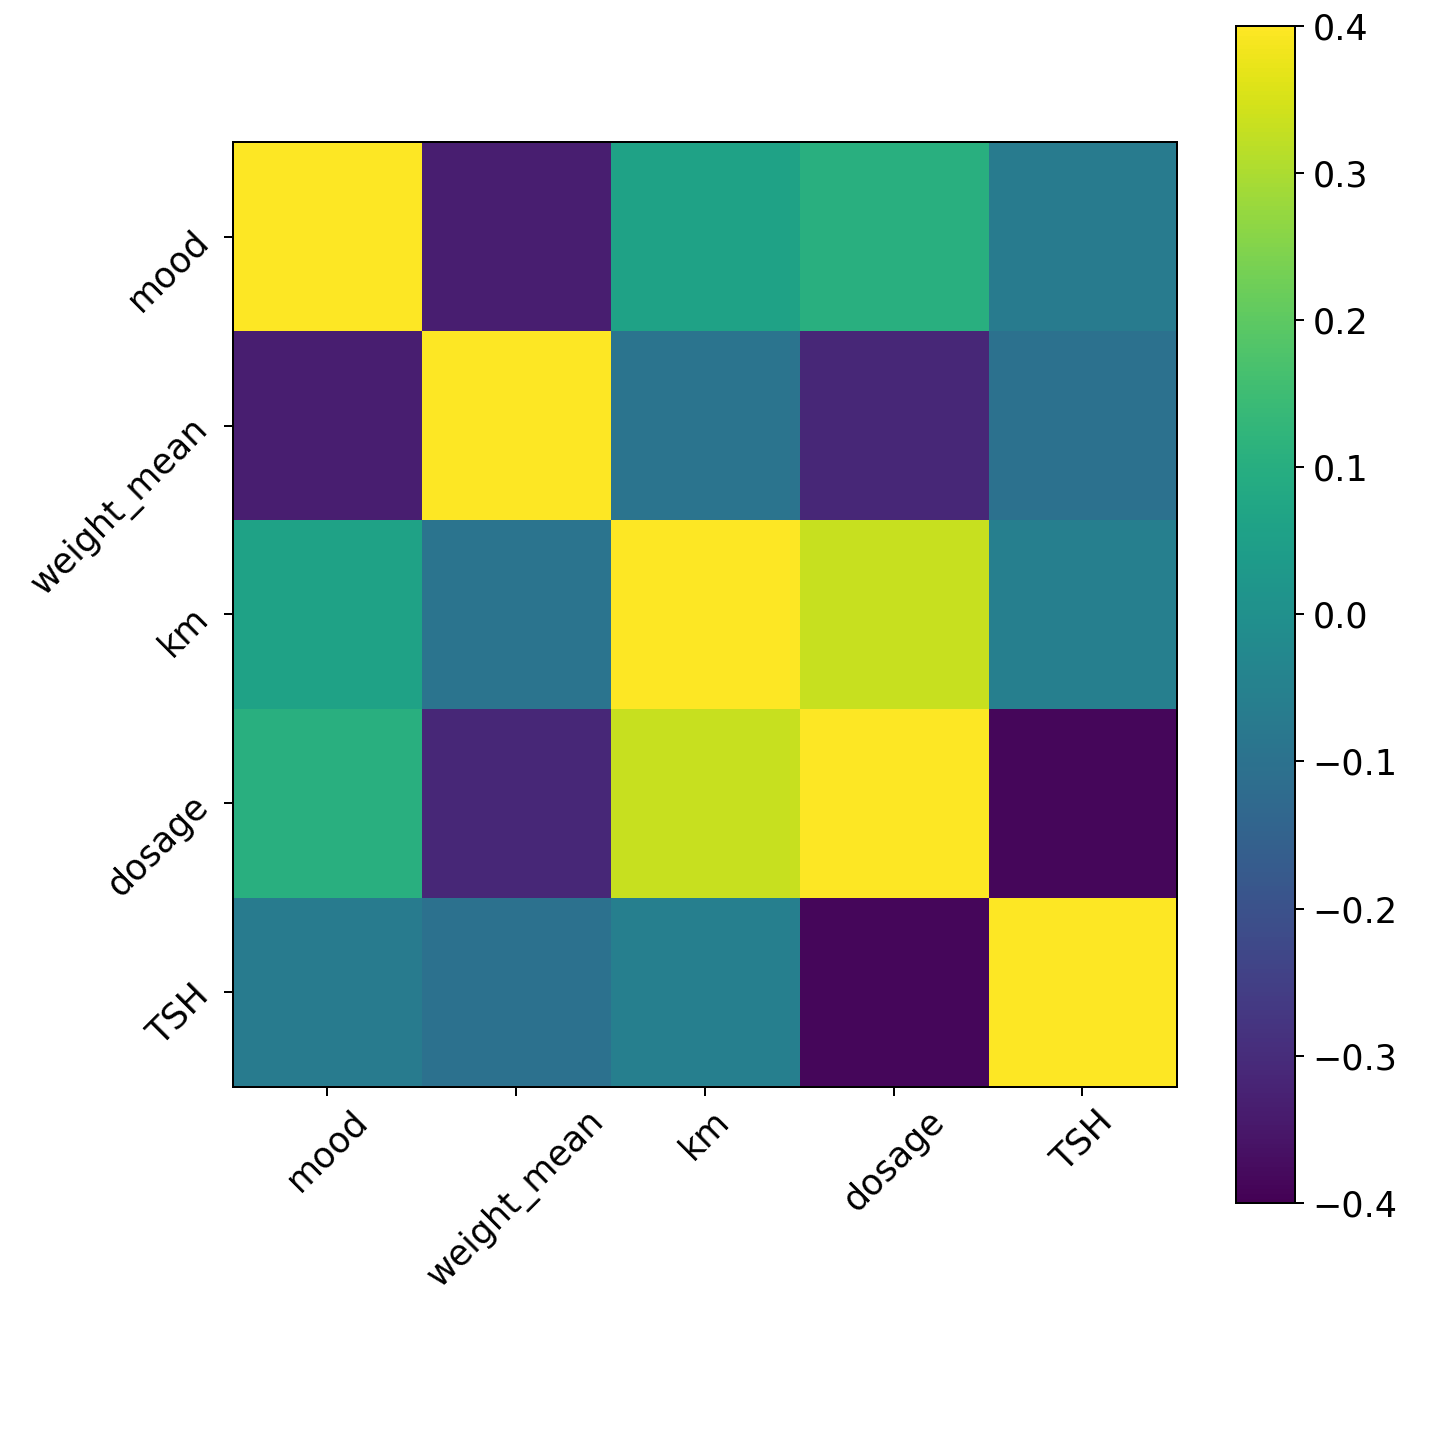

In [12]:
f = plt.figure(figsize=(8,8))
plt.imshow((df.corr()),vmin=-.4,vmax=.4)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.tight_layout()
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# plt.title('Correlation Matrix', fontsize=16);

# What do we see above?

- Well, for one thing which is conforting we see a correlation between the dosage of medication and the TSH. This is expected and indicates the quality our dataset. However this also sets the upper level of our correlations: Even for this two types of signals that are expected to be very correlated, we are observing a correlation of ~0.38.

- The dosage is positively correlated with the WalkingRunning distance. This is inline with the idea that the less dosage a person takes the more symptoms of tiredness appears. Therefore, in the light of this knowledge, the causality could be rather interpreted as wrong level of dosage being causally related to induce less activity —although what we see above is just correlation.

- Another strong correlation here is between the level of mood and weight. The negative correlation indicates that the more weight results in less happy mood.

Overall what we see here can be interpreted as having a low dosed thyroxine leading jointly or sequentially to less physical activity and increase in weight gain where ultimately leading to detrimental mood.

# Typical values analysis

What are the typical values for different levels of mood?

In [13]:
df_all["mood_groups"] = pd.qcut(df_all["mood"],q=[0,0.33, 0.66,1],labels=["low","medium","great"])

typical_values = df_all.groupby("mood_groups").mean().T
typical_values[:5]

mood_groups,low,medium,great
mood,7.951459,8.501190,9.093878
weight_mean,102.127593,100.996867,100.336474
km,0.182487,0.185142,0.187483
dosage,169.225685,168.685253,169.976488
TSH,2.599704,5.307326,2.810770


In [14]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

typical_values = df_all.groupby("mood_groups").sum().T
df_ = typical_values[5:]
df_.columns = df_.columns.add_categories(['sd'])
df_["sd"] = df_.std(axis=1)
df_ = df_.sort_values(by="sd",ascending=False).iloc[:,:3]
s = df_.style.background_gradient(cmap=cm)
s

/Users/onat/Documents/Code/Python/JupyterNotebooks/TSH/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


mood_groups,low,medium,great
pain_hip,1.000000,0.000000,0.000000
easy sweat,1.000000,0.000000,0.000000
hard stool,0.000000,1.000000,0.000000
sick_diarrhea,0.000000,0.000000,1.000000
pain_stomach,0.000000,0.000000,1.000000
sick_cold,0.896552,0.000000,0.103448
medium stool,0.194595,0.805405,0.000000
eyes hurte,0.808171,0.053286,0.138544
restless,0.245283,0.754717,0.000000
sick_migraine,0.254237,0.000000,0.745763


# What impacts on the mood

Assuming a linear relationship between mood and other variables, what are their contribution?

In [15]:
import sklearn.linear_model
from scipy.stats import zscore

regr = sklearn.linear_model.LinearRegression()

df  = df.apply(zscore,nan_policy='omit')
df_ = df.dropna()

cols = ["weight_mean","dosage","TSH","km"]

X = np.float64(df_[cols].values)
Y = np.ravel(np.array(df_[["mood"]].values))


print(X.shape, Y.shape)
regr.fit(X,Y)

(66, 4) (66,)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
for i,c in enumerate(cols):
    print('{} : {}'.format(c, regr.coef_[i]))
# The mean squared error

weight_mean : -0.6790450252927404
dosage : -0.03718316819771175
TSH : -0.08690466523124138
km : 0.2365474321341054


- Interesting to see that neither dosage nor TSH levels have much impact on the mood.
- the impact of weight on the mood is neearly 3 times more than the physical activity level.

# Get Activities and their cross-correlation

<IPython.core.display.Javascript object>


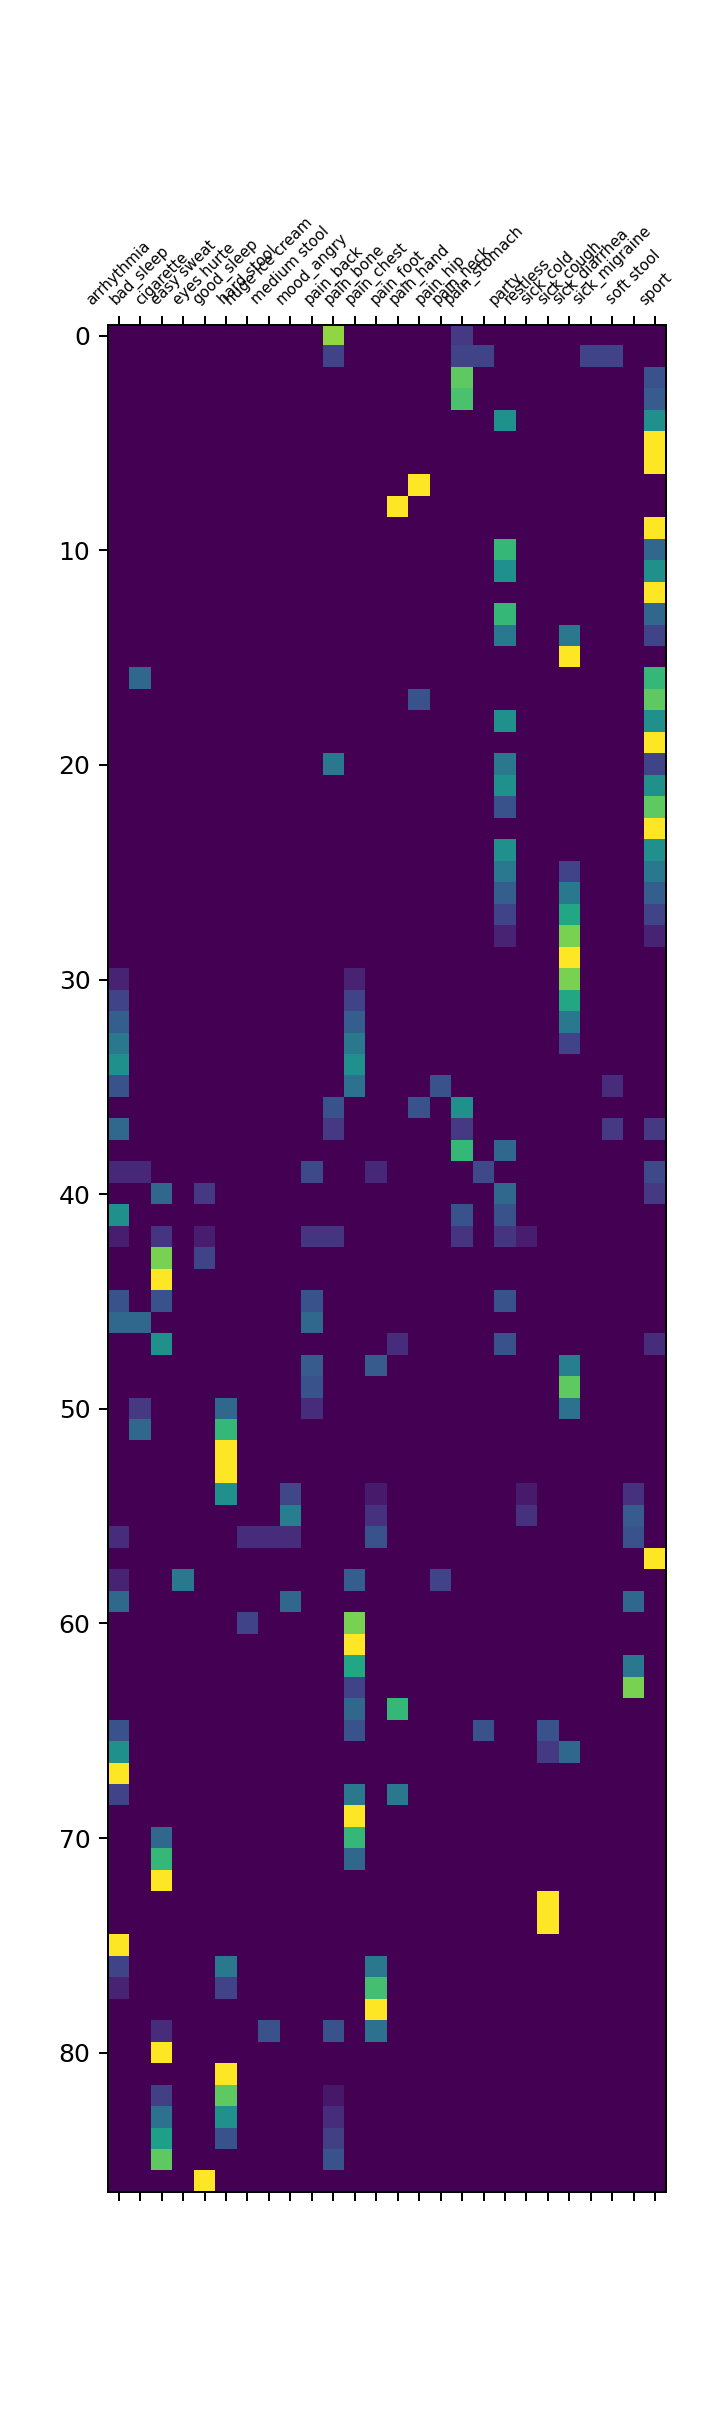

In [17]:
df_activities = act.resample(resample_grain).mean().interpolate(method='linear')
plt.matshow(df_activities)
plt.xticks(range(df_activities.shape[1]), df_activities.columns, fontsize=6, rotation=45);

<IPython.core.display.Javascript object>


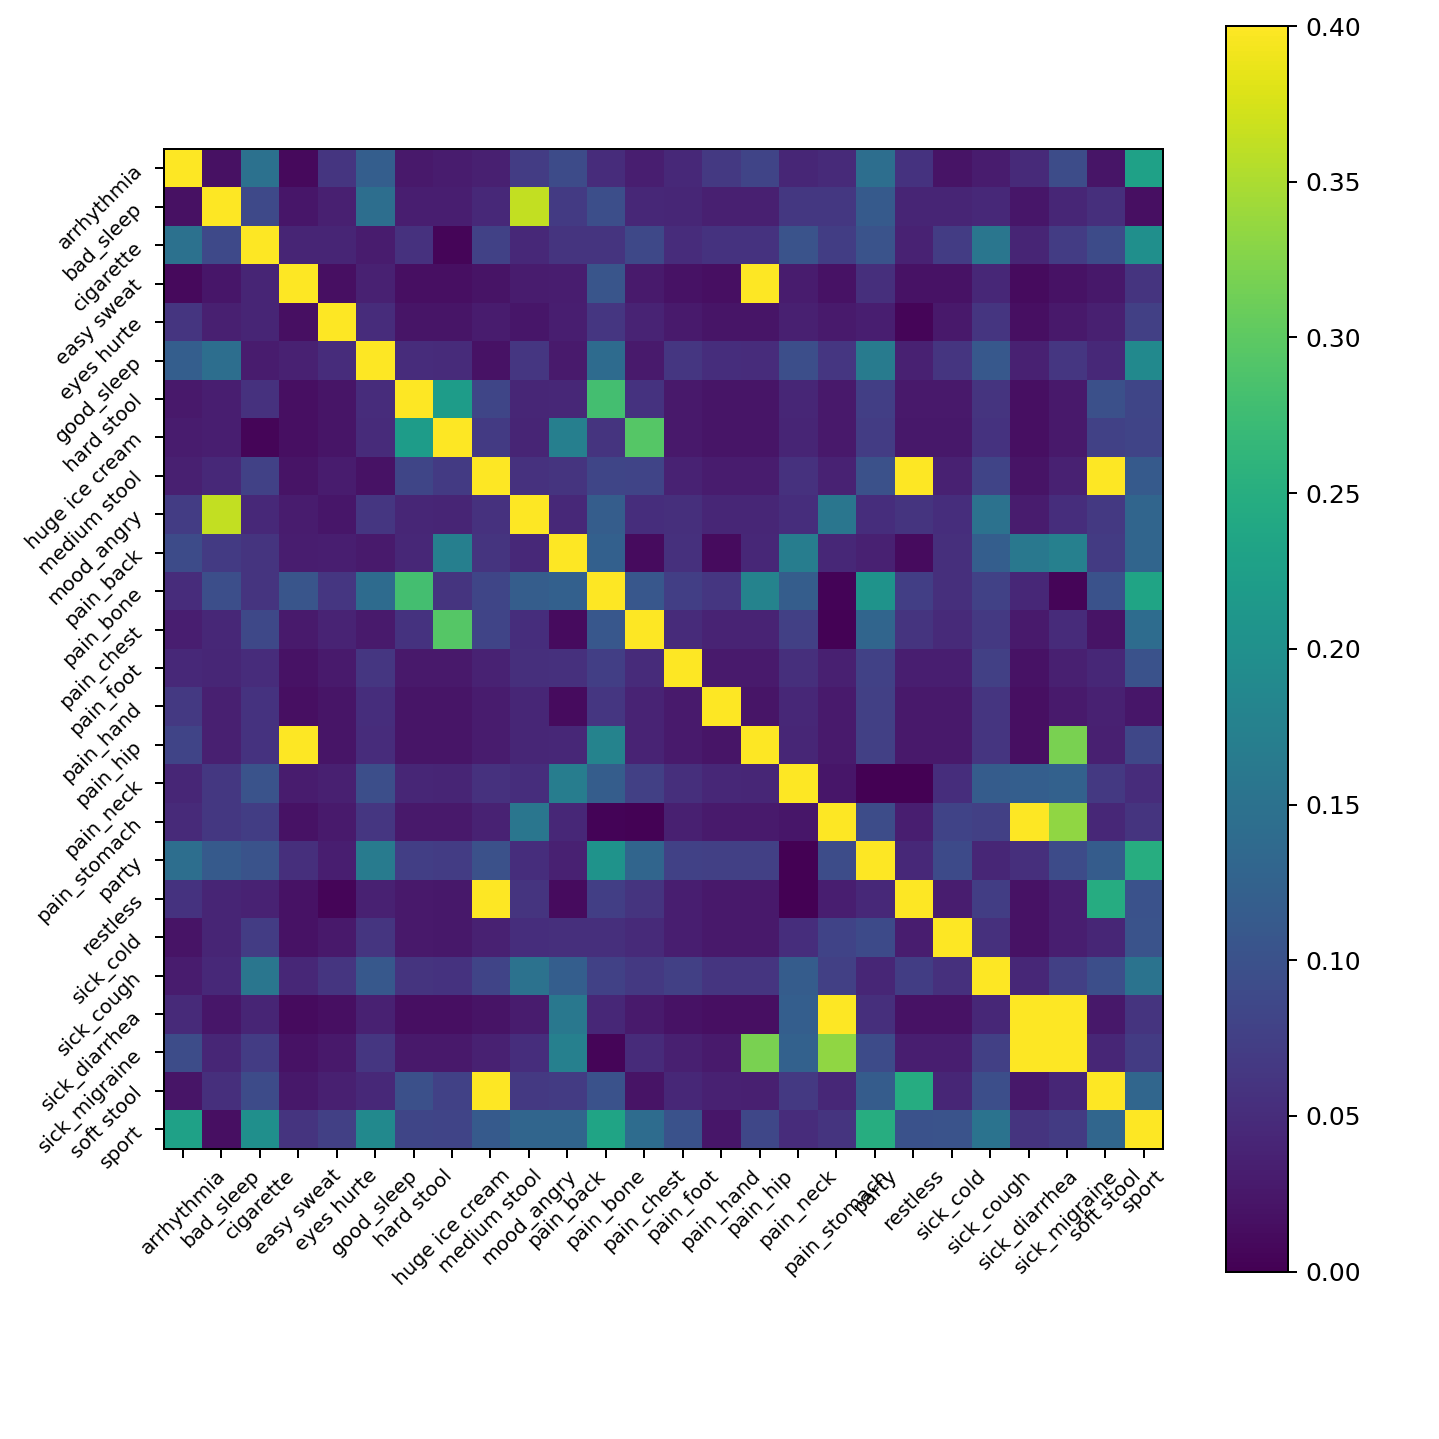

In [18]:
f = plt.figure(figsize=(8,8))
plt.imshow(np.abs(df_activities.corr()),vmin=0,vmax=.4)
plt.xticks(range(df_activities.shape[1]), df_activities.columns, fontsize=8, rotation=45)
plt.yticks(range(df_activities.shape[1]), df_activities.columns, fontsize=8, rotation=45)
plt.tight_layout()
cb = plt.colorbar()
# plt.title('Correlation Matrix', fontsize=16);